# SNR Grid Calculations Tutorial

In [1]:
# import some general packages
import sys,os
import matplotlib
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from matplotlib.colors import LogNorm
from datetime import date
from astropy import units as u

# make plot fonts big
font = {'size'   : 14}
matplotlib.rc('font', **font)

# Load path to package and load a few useful things
sys.path.append('/Users/huihaoz/specsim/utils/')
from objects import load_object
from load_inputs import fill_data
from functions import *
import plot_tools,obs_tools



In [2]:
import glob

In [3]:
zp_file='/Users/huihaoz/specsim/_Data/filters/zeropoints.txt'
filter_path='/Users/huihaoz/specsim/_Data/filters/'
band='J'
family='2mass'

In [4]:
glob.glob(filter_path + '*' + family + '*' + band + '.dat')[0]

'/Users/huihaoz/specsim/_Data/filters/2mass.J.dat'

## Loading Config File & Running an Observation

### Background
Key parameters are stored in the configuration file "hispec.cfg". The function "load_object" loads the contents of this configuration file into a storage object "so'. The objects.py function is a useful reference for seeing what is contained in so, but it has class attributes like 'stel' for stellar properties and 'track' for tracking camera properties. For example, the stellar temperature defined in the config file will be loaded and stored in "so.stel.teff".

The "fill_data" class takes the storage object and upon initiation, it fills the so object by running a bunch of things. As such, this process takes a little while - first it defines the wavelength grid (x) and yJHK filter bounds, then does the dirty work of loading, reinterpolating files, and calculating things in the following order:

**filter**
    (loads zeropoint and filter transmission curve for the band selected)

**stellar** 
    (loads the stellar spectrum based on the temperature chosen and scales it to the magnitude requested in the filter band set in the filter attribute of so)

**telluric**
    (loads the telluric spectrum and scales to the requested PWV and airmass)

**ao**
    (by default takes the magnitude of the star and uses input files to determine the expected WFE based on the AO mode selected which should match headers in the file. Or one can just set the params to some WFE)

**instrument**
    (loads the instrument transmission file if there is one, otherwise does HISPEC/MODHIS specific things and loads the base throughput and finds the coupling based on the WFE found previously assuming a specific file format)

**observe** 
    (takes all the loaded files to find the spectral flux at the instruments and degrades and resamples the spectrum according to the resolution and pixels provided. It also loads the background spectrum and noise to get the SNR per pixel and per resolution element)

**tracking** 
    (loads the tracking camera properties for the camera specified, loads the transmission file, interpolates, calculates the platescale, makes the tracking band transmission file, computs the PSF FWHM and the strehl, determines the sky and instrument background, computes the photons at the tracking camera, combines the noise, gives the SNR and expected centroid error
    
There are some other functions in the load_objects.py that can be used to reload a subset of things and are useful since there are a lot of orders of operations. These are still kinda confusing but I will demonstrate how I use them to cycle over a lot of parameters

## The Code - Running A Single Instance
Here is the code to load a config file and run it

In [5]:
configfile = '/Users/huihaoz/specsim/examples/modhis.cfg' # define our config file name and path

In [6]:
so    = load_object(configfile)     # Load the contents of the config file into the so "storage object"

In [7]:
cload = fill_data(so)               # Initiate the fill_data class which runs an observation and stores the results in so

------FILLING OBJECT--------
Teff set to 2800.0
K band mag set to 14.0
HO WFE V mag is 20.288981656569298
Tip Tilt V mag is 20.288981656569298
AO mode: LGS_OFF
HO WFE is 213.0
tt dynamic is 2.55
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(inst_bg + sky_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


Tracking FWHM=3.8487820712158713pix
Tracking photons: 135937.1085128926 e-
Tracking noise: 371.10655227311906 e-


In [10]:
len(so.inst.strehl)

4300000

# Plotting the Spectrum
There are several tools for plotting in plot_tools.py which we loaded earlier as plot_tools. Not all plot functions are currently working well and a lot require certain data paths to be fixed. 

Here is an example how to use some of the key ones that should work! For example, how to plot the SNR spectrum, the base throughput, the background noise, etc. These functions take the so object, so it plots the parameters stored in so from the latest run.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


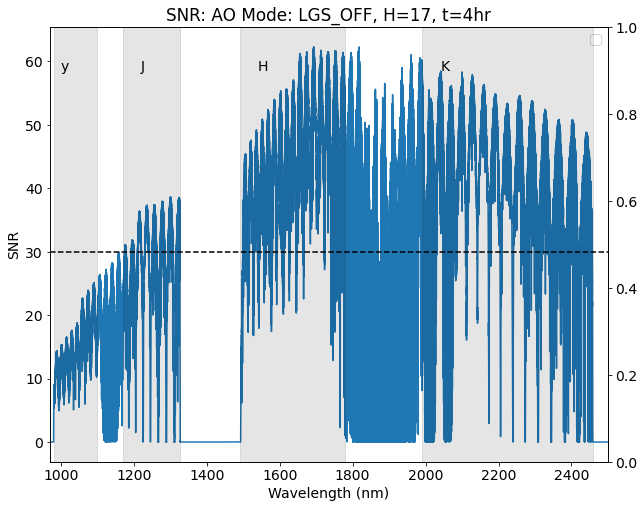

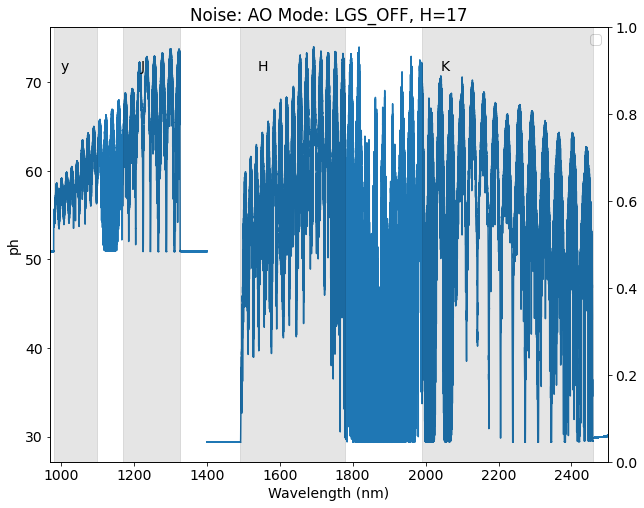

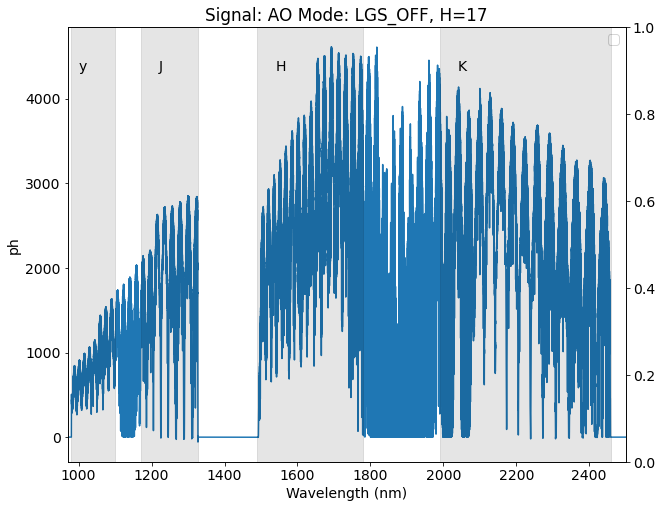

In [8]:
savepath = './'
#plot_tools.plot_ph_per_sec_nm(so,snrtype=0,savepath=savepath)
plot_tools.plot_snr(so,snrtype=0,savepath=savepath) #1
plot_tools.plot_noise(so,snrtype=0,savepath=savepath)
plot_tools.plot_photon(so,snrtype=0,savepath=savepath)
#plot_tools.plot_coupling(so,savepath=savepath) # these ones are weird
#plot_tools.plot_base_throughput(so,savepath=savepath)
#plot_tools.plot_tracking_bands(so,savepath=savepath)
#plot_tools.plot_background_spectra(so,savepath=savepath)

In [15]:
psisim_unit = (so.stel.s*u.ph / (u.nm * u.m**2 * u.s)).to(u.ph/(u.AA * u.s * u.cm**2))

Text(0, 0.5, 'Spectrum [ph/ Ang s cm2]')

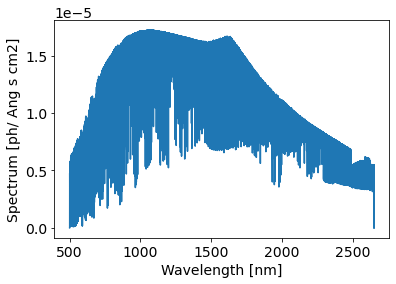

In [17]:
plt.plot(so.stel.v, psisim_unit)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Spectrum [ph/ Ang s cm2]")

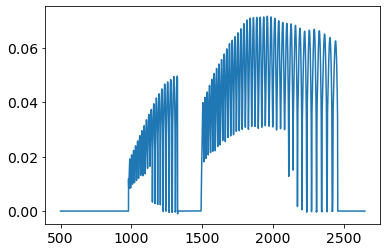

In [18]:
#plot_tools.plot_tracking_cam_spot_rms(camera='h2rg')
plt.plot(so.inst.xtransmit,so.inst.base_throughput * so.inst.coupling)

# Running a grid of parameters

# Future Implementation List

- add a function that prints key parameters defined in "so" - perhaps be able to print a summary for each item like telluric, stellar, etc. And also a general one

- make plotting scripts work, cut out ones that dont work or work on saved files not included in the utilities (e.g. only save plot scripts that plot things from so object)

- make things that point to a file path work from the config

- implement variable resolution

- implement testing functions to test things are working properly - one good test is to check the validity of magnitude conversions, like the colors of the given star can be checked

- comment objects.py and add all new variables to init